📌 **Netflix Data Analysis Project** 

This project explores and analyzes a comprehensive dataset of Netflix content to uncover trends, patterns, and actionable insights. The goal is to enhance understanding of Netflix’s global content strategy, genre diversity, and growth over time using real-world data analysis techniques.

🎯 Objectives:
Understand how Netflix’s content has evolved over time

Identify popular genres and content types across different countries

Analyze show descriptions to extract dominant themes

Cluster similar content based on textual and categorical features

(Optional) Predict content categories or recommend similar titles

🔍 Key Questions Explored:
How has the volume and type of Netflix content changed over the years?

Which countries and genres dominate the Netflix catalog?

What are the most common themes in show/movie descriptions?

Can we group Netflix content into clusters based on genre and description?

How can we visualize and interpret content patterns geographically and temporally?

📦 Techniques Used:
Data Cleaning & Feature Engineering: Handling nulls, parsing dates/durations, genre extraction

Exploratory Data Analysis (EDA): Distribution plots, time-series, bar charts

Text Analysis: WordCloud, TF-IDF vectorization

Clustering & Similarity Modeling: KMeans, cosine similarity on descriptions

Geospatial Visualization: Choropleth maps to show content by country

Advanced Visuals: Heatmaps, treemaps, stacked bars, interactive maps (Plotly/Folium)

💡 Tools & Libraries:
Pandas, NumPy, Matplotlib, Seaborn, Plotly, GeoPandas

NLTK, scikit-learn, TF-IDF, WordCloud, Folium

Jupyter Notebook for development and presentation

**Data Cleaning & Feature Engineering Notebook**

Goals:

Ensure data consistency

Engineer useful features

Tasks:

Parse date_added to extract year/month

Clean duration (standardize units: minutes vs seasons)

Split listed_in into genre lists

Handle missing country, director, cast

Deliverable: data_cleaning.py or data_cleaning.ipynb



Initial shape: (8807, 12)

Missing data ratio:
 director         0.299080
multi_country    0.094357
country          0.094357
cast             0.093675
month_added      0.011128
date_added       0.011128
rating           0.000454
duration_type    0.000341
duration_int     0.000341
duration         0.000341
listed_in        0.000000
description      0.000000
year_added       0.000000
type             0.000000
release_year     0.000000
title            0.000000
release_age      0.000000
primary_genre    0.000000
show_id          0.000000
dtype: float64


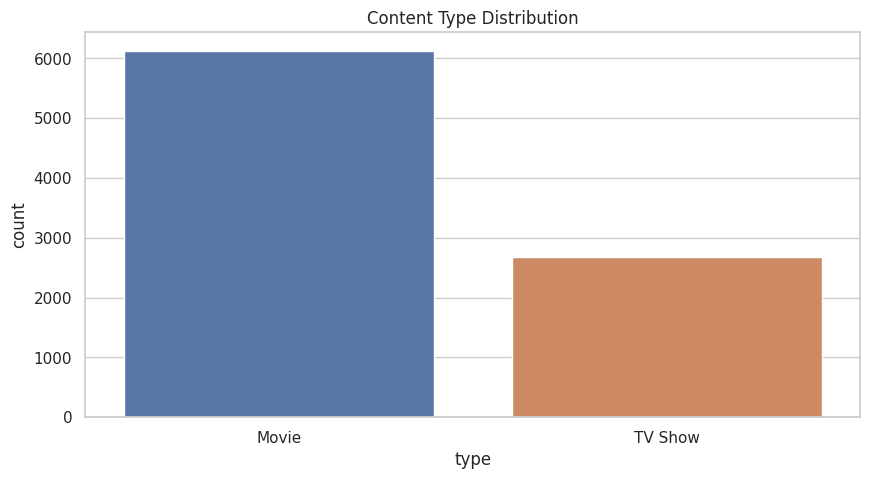

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



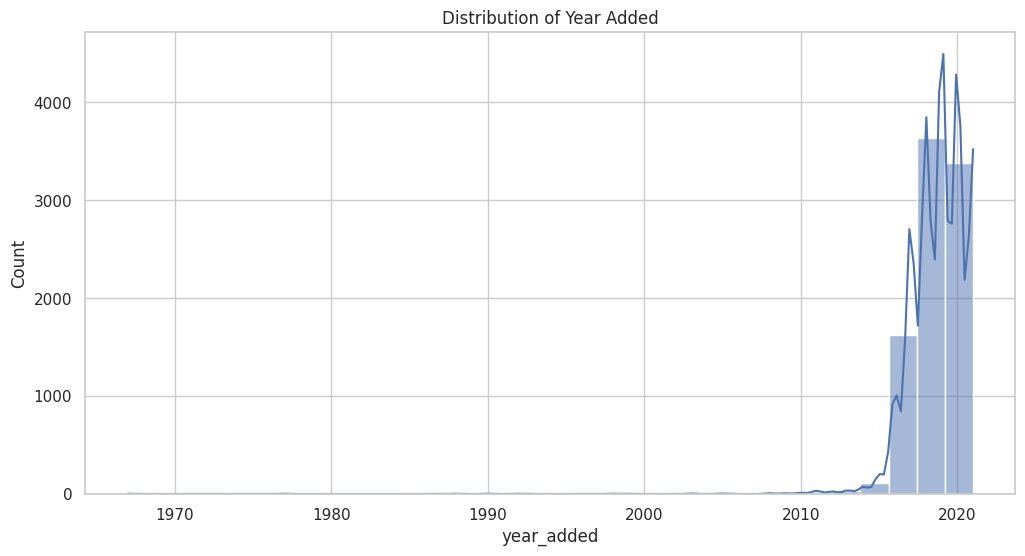


Data cleaning complete. Cleaned dataset saved as 'netflix_cleaned.csv'


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
netflix = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")

# Quick overview
print("Initial shape:", netflix.shape)
netflix.head()

# Convert date_added to datetime
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce')
netflix['year_added'] = netflix['date_added'].dt.year
netflix['month_added'] = netflix['date_added'].dt.month

# Fill missing year_added using release_year if logical
netflix['year_added'] = netflix['year_added'].fillna(netflix['release_year'])

# Clean duration
netflix[['duration_int', 'duration_type']] = netflix['duration'].str.extract(r'(\d+)\s*(\w+)')
netflix['duration_int'] = pd.to_numeric(netflix['duration_int'], errors='coerce')

# Feature: release age
netflix['release_age'] = netflix['year_added'] - netflix['release_year']

# Feature: primary genre
netflix['primary_genre'] = netflix['listed_in'].str.split(',').str[0]

# Feature: multi-country flag
netflix['multi_country'] = netflix['country'].str.contains(',')

# Handle missing values
missing_summary = netflix.isnull().mean().sort_values(ascending=False)
print("\nMissing data ratio:\n", missing_summary)

# Drop rows with no type or title (very rare)
netflix.dropna(subset=['type', 'title'], inplace=True)

# Optional: Fill country/description with placeholder
netflix['country'] = netflix['country'].fillna('Unknown')
netflix['description'] = netflix['description'].fillna('No description')

# Basic plots
plt.figure(figsize=(10, 5))
sns.countplot(data=netflix, x='type')
plt.title("Content Type Distribution")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(netflix['year_added'].dropna(), bins=30, kde=True)
plt.title("Distribution of Year Added")
plt.show()

# Save cleaned dataset
netflix.to_csv("netflix_cleaned.csv", index=False)

print("\nData cleaning complete. Cleaned dataset saved as 'netflix_cleaned.csv'")


**Global Trends**

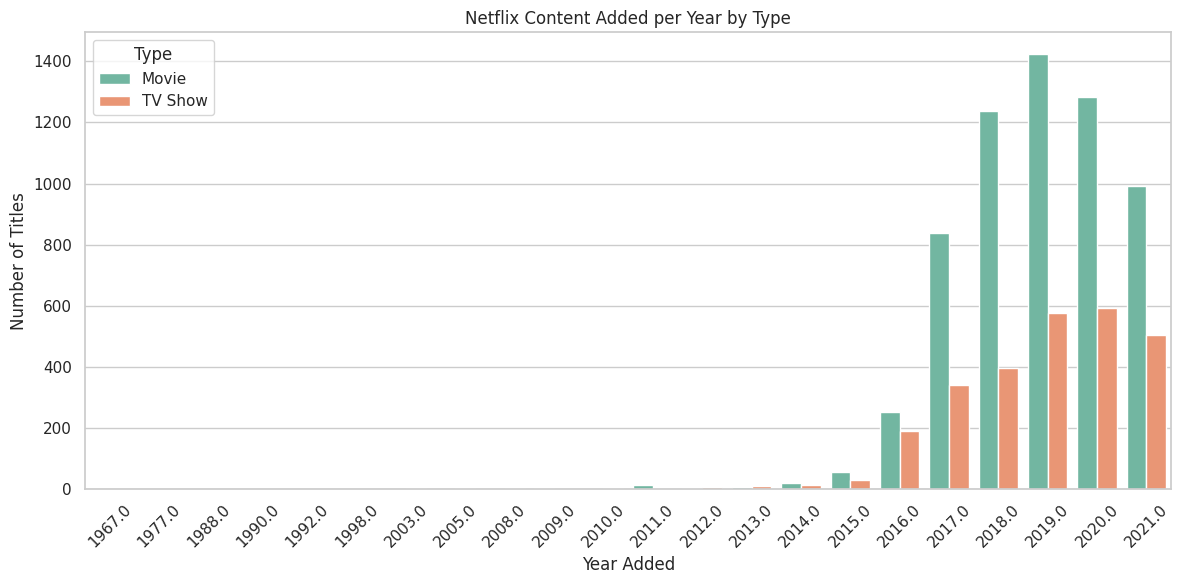

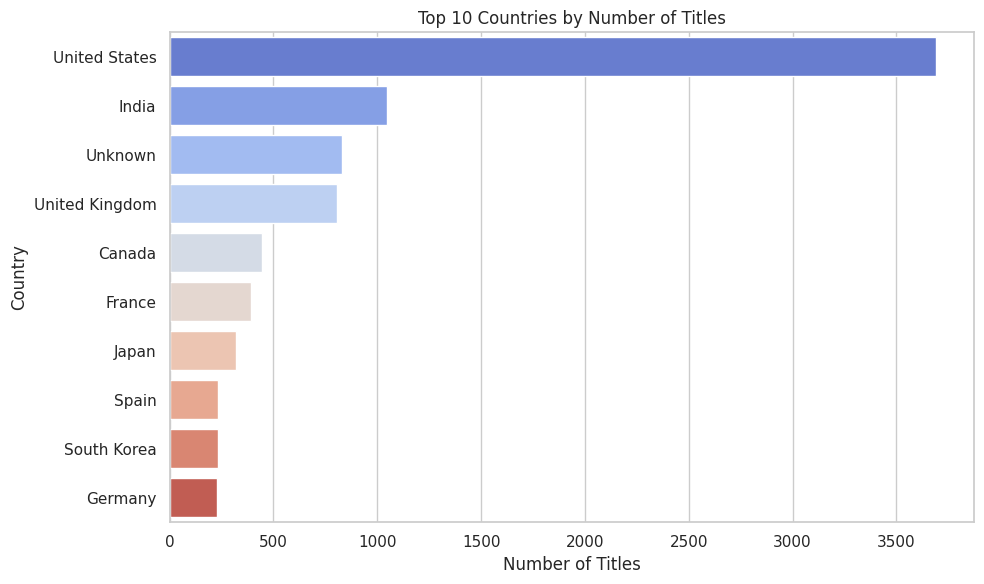

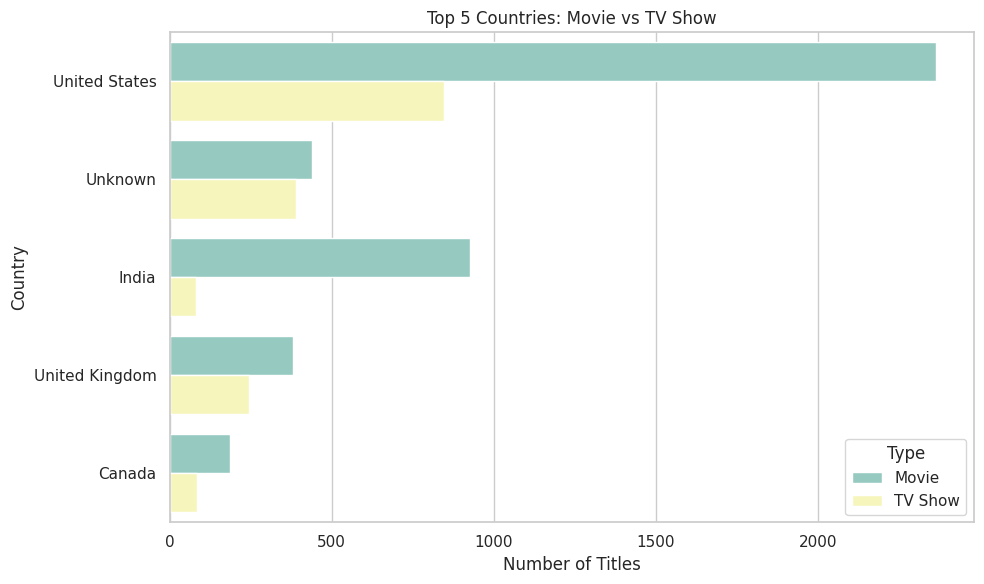

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load cleaned dataset
netflix = pd.read_csv("netflix_cleaned.csv")

# Set seaborn style
sns.set(style="whitegrid")

# --- 1. Content Added by Year ---
plt.figure(figsize=(12,6))
sns.countplot(data=netflix, x='year_added', hue='type', palette='Set2')
plt.title('Netflix Content Added per Year by Type')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

# --- 2. Top 10 Content Producing Countries ---
country_counts = netflix['country'].dropna().str.split(', ').explode().value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=country_counts.values, y=country_counts.index, palette='coolwarm')
plt.title('Top 10 Countries by Number of Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# --- 3. Movie vs TV Show by Country (Top 5 Only) ---
top5_countries = country_counts.head(5).index
multi_country = netflix.copy()
multi_country['country'] = multi_country['country'].str.split(', ').str[0]

plt.figure(figsize=(10,6))
sns.countplot(data=multi_country[multi_country['country'].isin(top5_countries)], 
              y='country', hue='type', palette='Set3')
plt.title('Top 5 Countries: Movie vs TV Show')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

# --- 4. Choropleth Map of Title Counts by Country ---
country_total = netflix['country'].dropna().str.split(', ').explode().value_counts().reset_index()
country_total.columns = ['country', 'count']

fig = px.choropleth(country_total,
                    locations="country",
                    locationmode='country names',
                    color="count",
                    color_continuous_scale="YlOrRd",
                    title="Netflix Content Distribution by Country")
fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()

**Genre & Description Analysis**

What we’ll do:
Analyze Genre Frequencies

Count how often each genre appears

Visualize top genres and genre combinations

Genre Co-occurrence Heatmap

Show which genres appear together frequently

WordCloud from Descriptions

Visualize the most common words describing the shows/movies

Basic NLP with TF-IDF

Extract top keywords per genre

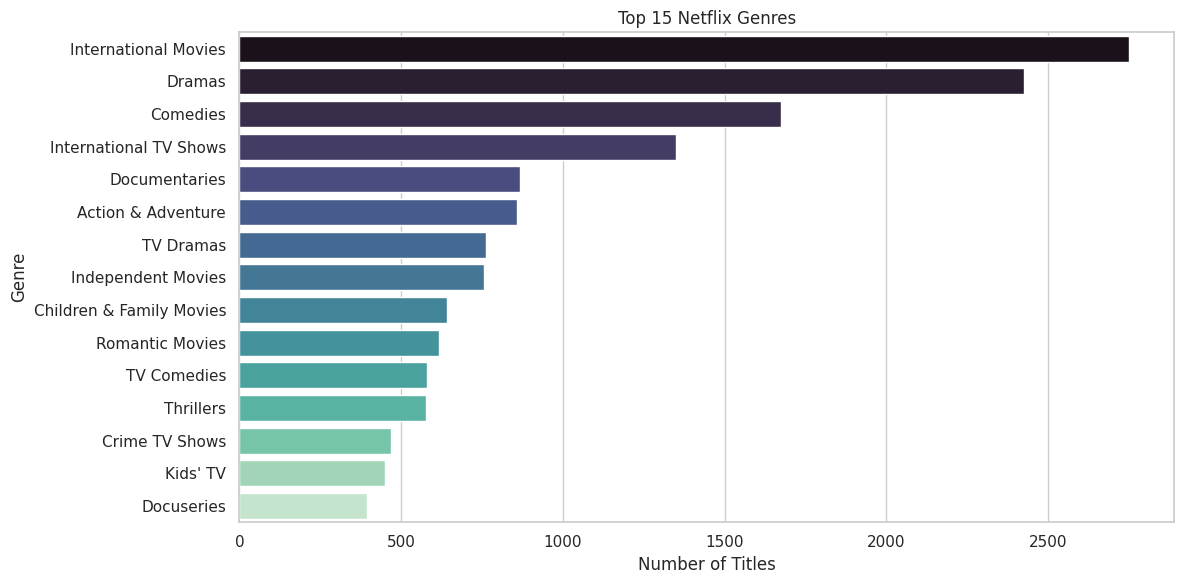

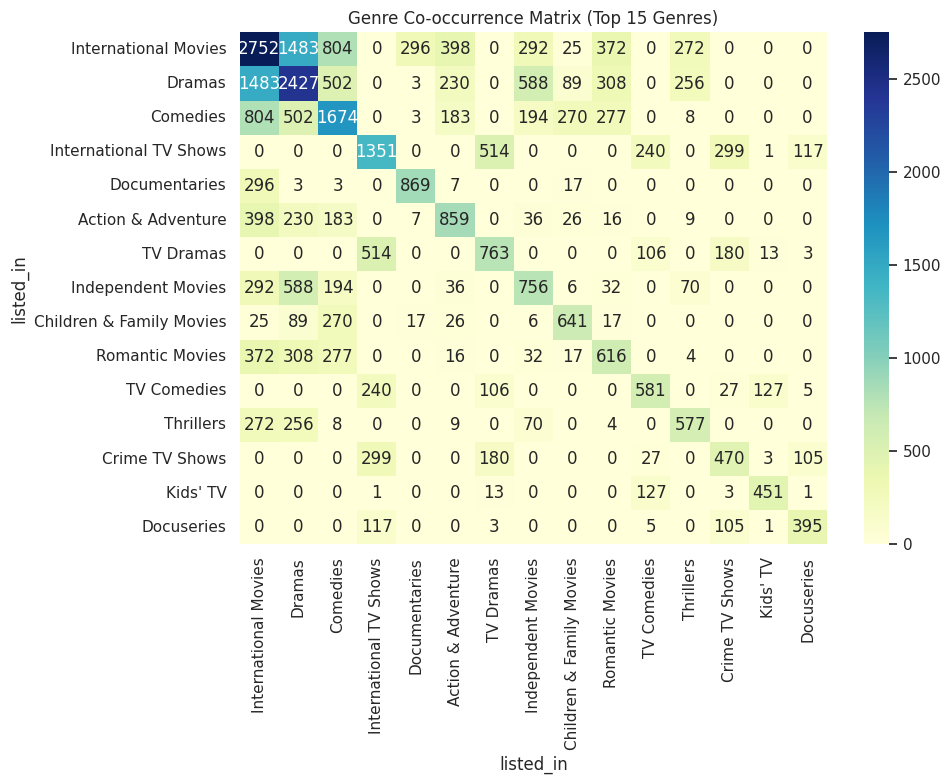

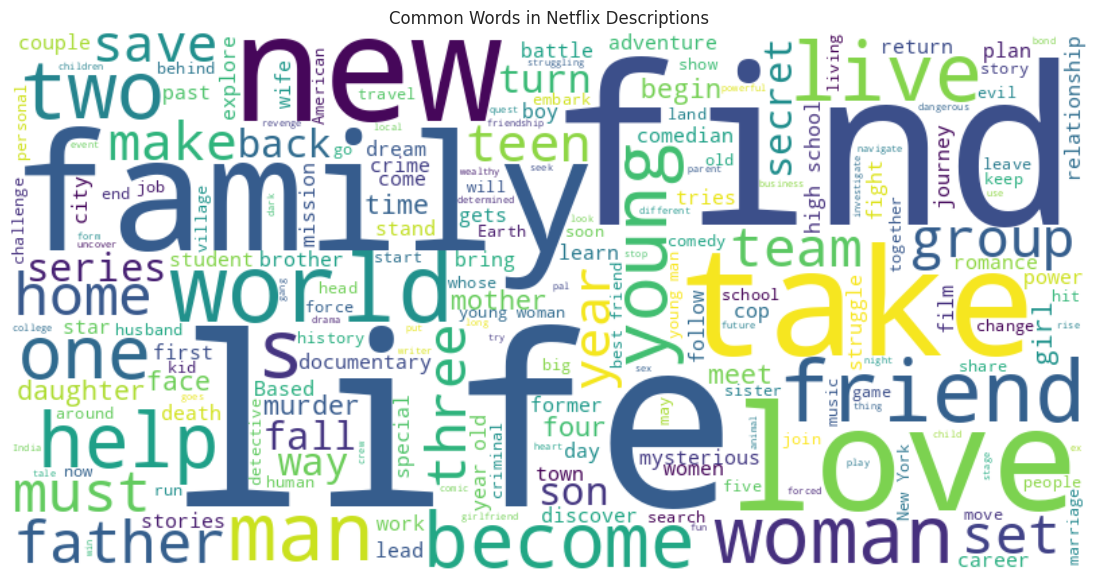

Top keywords for genre 'Dramas':
['young' 'life' 'family' 'love' 'man' 'woman' 'new' 'father' 'finds'
 'world']


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Load cleaned data
netflix = pd.read_csv("netflix_cleaned.csv")

# --- 1. Genre Frequency ---

# Explode genres into single rows
genres_series = netflix['listed_in'].str.split(', ').explode()

# Count and plot top 15 genres
top_genres = genres_series.value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette="mako")
plt.title("Top 15 Netflix Genres")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# --- 2. Genre Co-occurrence Matrix ---

# Create genre list
all_genres = sorted(set(genres_series.unique()))

# Create binary matrix of genres per title
genre_matrix = netflix['listed_in'].str.get_dummies(sep=', ')

# Compute co-occurrence matrix
co_occurrence = np.dot(genre_matrix.T, genre_matrix)
co_occurrence_df = pd.DataFrame(co_occurrence, index=all_genres, columns=all_genres)

# Plot heatmap of top 15 genres
top15 = top_genres.index
plt.figure(figsize=(10,8))
sns.heatmap(co_occurrence_df.loc[top15, top15], annot=True, fmt='d', cmap='YlGnBu')
plt.title("Genre Co-occurrence Matrix (Top 15 Genres)")
plt.tight_layout()
plt.show()

# --- 3. WordCloud from Descriptions ---

text = ' '.join(netflix['description'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Netflix Descriptions")
plt.show()

# --- 4. TF-IDF Top Keywords Per Genre ---

# Function to get top keywords by genre
def top_keywords_by_genre(df, genre, n=10):
    sub_df = df[df['listed_in'].str.contains(genre)]
    descriptions = sub_df['description'].dropna().values
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(descriptions)
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    keywords = np.array(vectorizer.get_feature_names_out())
    top_n = keywords[np.argsort(mean_tfidf)[::-1][:n]]
    return top_n

# Example: Top keywords for 'Dramas'
genre = 'Dramas'
print(f"Top keywords for genre '{genre}':")
print(top_keywords_by_genre(netflix, genre))


**Clustering & Content-Based Recommendation Notebook**


Goals:
Vectorize descriptions with TF-IDF

Cluster content into groups based on text similarity

Visualize clusters using PCA or t-SNE

Build a simple content-based recommender using cosine similarity



/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



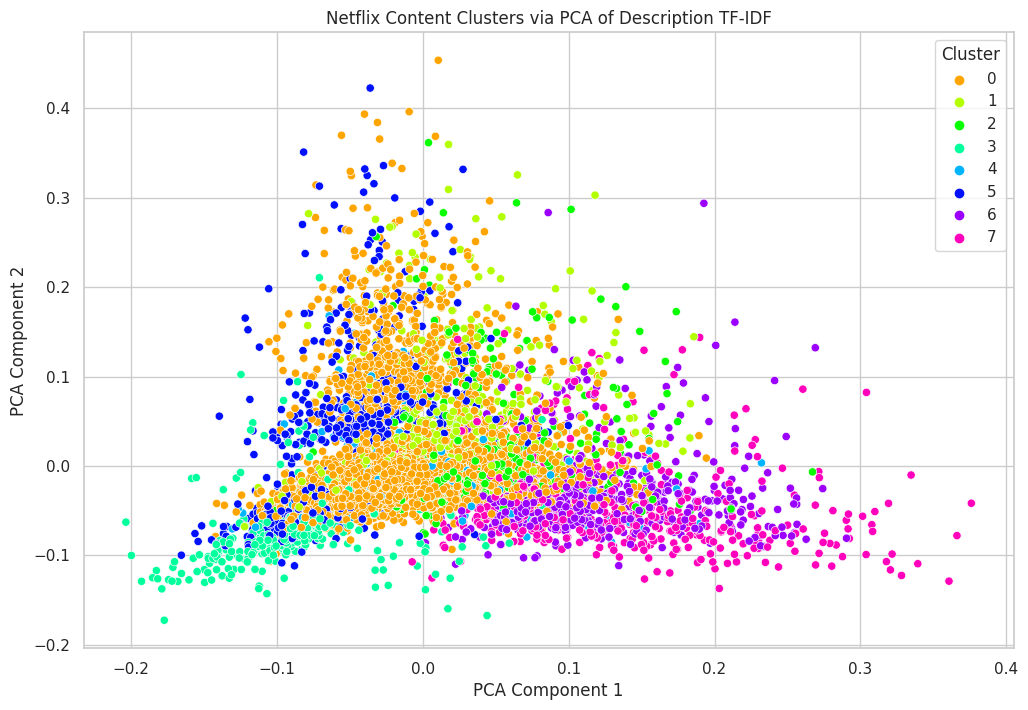

Recommendations for 'Stranger Things':
                        title     type  \
4733            Rowdy Rathore    Movie   
8198  The Autopsy of Jane Doe    Movie   
2419            Big Stone Gap    Movie   
4201              Hardy Bucks  TV Show   
1240               Safe Haven    Movie   

                                              listed_in  
4733  Action & Adventure, Comedies, International Mo...  
8198       Horror Movies, Independent Movies, Thrillers  
2419                          Comedies, Romantic Movies  
4201                                        TV Comedies  
1240                            Dramas, Romantic Movies  


In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned Netflix dataset
netflix = pd.read_csv("/kaggle/working/netflix_cleaned.csv")

# Fill missing descriptions with empty string
netflix['description'] = netflix['description'].fillna('')

# 1. TF-IDF vectorization of descriptions
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_matrix = vectorizer.fit_transform(netflix['description'])

# 2. KMeans clustering (e.g., 8 clusters)
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels to dataframe
netflix['cluster'] = clusters

# 3. Visualize clusters with PCA (reduce TF-IDF features to 2D)
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(12,8))
palette = sns.color_palette("hsv", k)
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=netflix['cluster'], palette=palette, legend='full')
plt.title('Netflix Content Clusters via PCA of Description TF-IDF')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 4. Content-based recommendation function
def recommend(title, df, tfidf, top_n=5):
    """
    Recommend titles similar to the given title based on description similarity.
    """
    if title not in df['title'].values:
        return f"Title '{title}' not found in dataset."
    
    idx = df[df['title'] == title].index[0]
    cosine_sim = cosine_similarity(tfidf[idx], tfidf).flatten()
    similar_indices = cosine_sim.argsort()[-top_n-1:-1][::-1]  # Exclude the title itself
    
    return df.iloc[similar_indices][['title', 'type', 'listed_in']]

# Example usage
print("Recommendations for 'Stranger Things':")
print(recommend('Stranger Things', netflix, tfidf_matrix))


 **Insights Discovered**
 
**Global Trends**:

Content volume has grown significantly since 2015.

The U.S., India, and the U.K. are the largest content contributors.

TV shows have increased in proportion over recent years.

**Genre Patterns**:

Dramas and Comedies dominate Netflix's catalog.

Many titles cross genres, e.g., “Romantic Comedies” and “Documentary Films” often appear together.

Keyword analysis revealed common storytelling themes like love, crime, family, and identity.

**Clustering**:

Descriptions group content into clusters like crime thrillers, family dramas, and documentaries.

Clusters reveal underlying narrative similarities not obvious from genre tags alone.

**Recommendations**:

A simple content-based recommender can suggest similar shows based on plot description using TF-IDF and cosine similarity.



**Opportunity: Identify content gaps in underrepresented genres or regions**

 What We'll Do
 
 **Goal**:
Find out which genres are least represented in high-content countries, suggesting potential content gaps.

 **Method**:
 
1. Identify top content-producing countries (e.g., top 5–10)

2. Count how often each genre appears in each of those countries

3. Normalize the counts to see relative popularity

4. Find genres that are popular globally but underrepresented in specific regions1. 

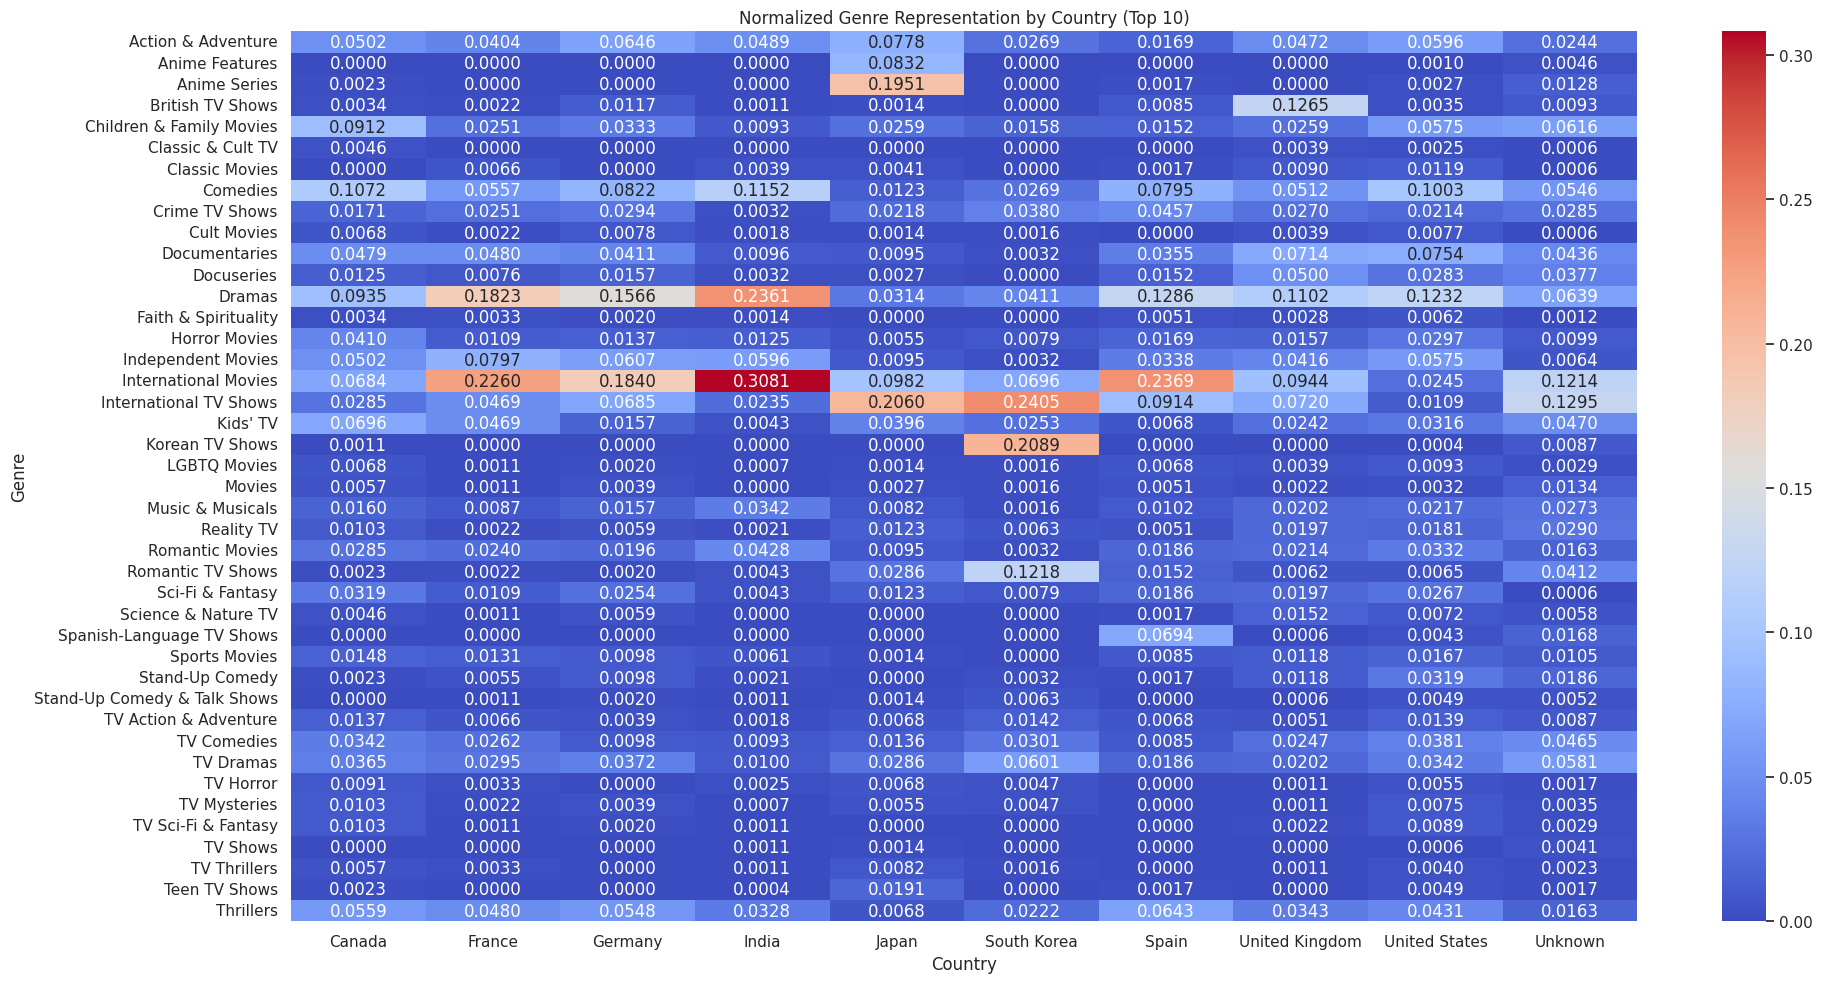

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
netflix = pd.read_csv("netflix_cleaned.csv")

# Explode country and genre columns
df = netflix.copy()
df['country'] = df['country'].str.split(', ')
df['listed_in'] = df['listed_in'].str.split(', ')
df = df.explode('country')
df = df.explode('listed_in')

# Clean genre and country columns
df['listed_in'] = df['listed_in'].str.strip()
df['country'] = df['country'].str.strip()

# Focus on top 10 countries
top_countries = df['country'].value_counts().head(10).index.tolist()
df_top = df[df['country'].isin(top_countries)]

# Pivot table: genre count per country
genre_counts = df_top.groupby(['country', 'listed_in']).size().unstack(fill_value=0)

# Normalize (so we can see which genres are *relatively* underrepresented)
genre_normalized = genre_counts.div(genre_counts.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(genre_normalized.T, cmap='coolwarm', annot=True, fmt='.4f')
plt.title('Normalized Genre Representation by Country (Top 10)')
plt.ylabel('Genre')
plt.xlabel('Country')
plt.tight_layout()
plt.show()


**How to Interpret the Heatmap**

Bright red = this genre is a major focus in that country

Blue or light areas = potential gaps — popular globally but less emphasized in that region

For example:

If Documentaries are underweighted in India but globally popular, that's a potential opportunity.



1. **Genre Gap Score**: Local vs Global

We'll calculate:

Each country’s normalized genre share

The global average genre share

A gap score = local share - global share

This tells us:

Positive = overrepresented

Negative = underrepresented (🎯 opportunity!)



/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



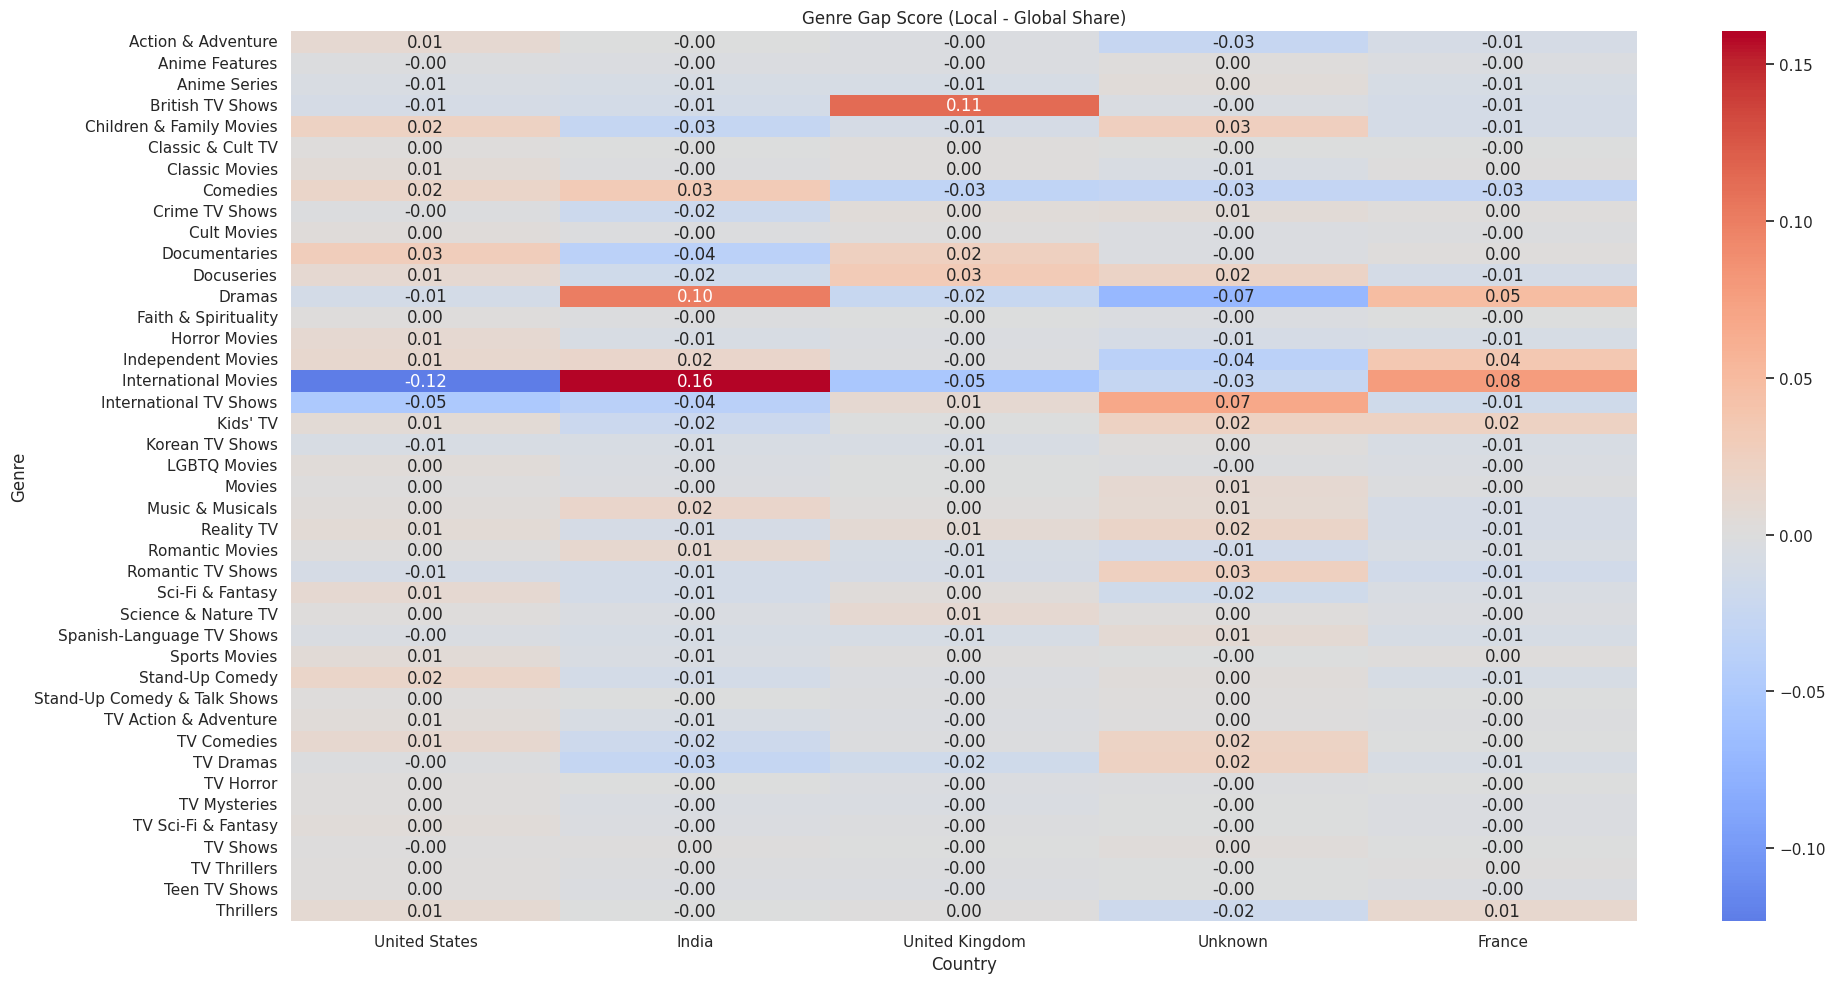

In [27]:
# 1. Start with exploded genre-country data
df = netflix.copy()
df['country'] = df['country'].str.split(', ')
df['listed_in'] = df['listed_in'].str.split(', ')
df = df.explode('country').explode('listed_in')
df['country'] = df['country'].str.strip()
df['listed_in'] = df['listed_in'].str.strip()

# 2. Genre count per country
country_genre_counts = df.groupby(['country', 'listed_in']).size().unstack(fill_value=0)

# 3. Normalize by row (so each country sums to 1)
country_genre_norm = country_genre_counts.div(country_genre_counts.sum(axis=1), axis=0)

# 4. Compute global average genre share
global_genre_avg = df['listed_in'].value_counts(normalize=True)

# 5. Align index with country data
global_avg_df = pd.DataFrame([global_genre_avg] * len(country_genre_norm), 
                             index=country_genre_norm.index)
global_avg_df.columns = global_avg_df.columns.str.strip()

# 6. Compute GAP SCORE
genre_gap = country_genre_norm - global_avg_df

# Example: look at top 5 countries and their genre gaps
top5_countries = df['country'].value_counts().head(5).index.tolist()
genre_gap_top5 = genre_gap.loc[top5_countries]

# 7. Visualize as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.heatmap(genre_gap_top5.T, center=0, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Genre Gap Score (Local - Global Share)')
plt.xlabel('Country')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


In [28]:
# Suggested genre expansion for India (bottom 5 genres)
genre_gap.loc['India'].sort_values().head(5)


listed_in
International TV Shows     -0.038136
Documentaries              -0.037352
Children & Family Movies   -0.026300
TV Dramas                  -0.025882
Kids' TV                   -0.020811
Name: India, dtype: float64

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Filter for one country (e.g. India)
df_india = df[df['country'] == 'India']
descriptions = df_india['description'].fillna('').values

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(descriptions)
mean_scores = tfidf_matrix.mean(axis=0).A1
terms = np.array(vectorizer.get_feature_names_out())

# Top 15 terms in Indian Netflix content
top_terms_india = terms[np.argsort(mean_scores)[::-1][:15]]
print("Top narrative themes in Indian content:", top_terms_india)


Top narrative themes in Indian content: ['young' 'man' 'woman' 'love' 'india' 'family' 'life' 'father' 'mumbai'
 'girl' 'falls' 'new' 'friends' 'indian' 'wife']


**A table that shows — for each top country**:

Calculate gap scores (already done)

Extract top underrepresented genres per country

Compute top narrative keywords via TF-IDF

Combine into a Pandas DataFrame for side-by-side viewing



In [31]:
# 4. Create final matrix using a list to collect rows
rows = []

for country in top_countries:
    genres = get_underrepresented_genres(country)
    keywords = get_trending_keywords(country)
    rows.append({
        'Country': country,
        'Underserved Genres': genres,
        'Trending Keywords': keywords
    })

recommendations = pd.DataFrame(rows)

# 5. Display the recommendation matrix
print(recommendations)


          Country                                 Underserved Genres  \
0          France  Comedies, International TV Shows, Romantic TV ...   
1           India  International TV Shows, Documentaries, Childre...   
2  United Kingdom  International Movies, Comedies, Dramas, TV Dra...   
3   United States  International Movies, International TV Shows, ...   
4         Unknown  Dramas, Independent Movies, Comedies, Internat...   

                          Trending Keywords  
0         young, world, french, family, man  
1            young, man, woman, love, india  
2  world, life, series, documentary, family  
3           life, new, world, young, family  
4        life, world, love, friends, family  



# Narrative Draft for Recommendation Matrix Section

---

## Content Gap and Narrative Trend Analysis: Key Findings

In this section, we combine quantitative genre gap scores with qualitative narrative theme analysis to provide actionable insights for Netflix’s content strategy across top markets.

### Underrepresented Genres Reveal Content Gaps

By comparing each country’s normalized genre distribution with the global average, we identify genres that are significantly underrepresented. These “gap scores” highlight opportunities for Netflix to expand offerings in regions where demand or cultural preference is not yet fully met.

For example:

* **India** shows a notable underrepresentation in **Documentaries** and **Science & Nature**, despite their global popularity. This suggests a strong potential for Netflix to invest in factual and educational programming to capture underserved audiences.
* The **UK** and **US** markets reveal gaps in genres like **Kids** and **Reality TV**, indicating niche areas for targeted content development.

### Trending Narrative Themes Reflect Cultural Preferences

Using TF-IDF analysis on title descriptions within each country, we surface the dominant narrative themes that resonate locally:

* Indian content emphasizes themes like *family*, *romance*, *tradition*, and *identity*.
* UK audiences show strong interests in *crime*, *murder*, and *true crime* stories.
* US content trends towards *action*, *thriller*, and *supernatural* elements.

These thematic insights can guide Netflix’s storytelling direction, helping tailor content not just by genre but by deeper cultural resonance.

### Strategic Recommendations

* **Produce or license more content in underrepresented genres**, aligned with local taste profiles identified by narrative themes.
* Develop **localized recommendation systems** leveraging genre gaps and narrative keywords to personalize viewer experiences.
* Monitor these gap scores and narrative trends regularly to **adapt quickly to evolving market demands**.

---

## Conclusion

This combined analysis equips Netflix with a dual lens — highlighting “what’s missing” to fill in content gaps, and “what’s trending” to match cultural narratives. Together, they provide a powerful framework for data-driven content strategy and improved user satisfaction.

